<h1>Batch processing of security trading data from Xetra trading system</h1>
<h2>Introduction</h2>
<p align="justify">The Deutsche Börse is a marketplace organizer for the trading of shares and other securities. This company publishes open data for every security traded on a minuteby-minute basis, for two different trading systems, Xetra and Eurex. Following analaysis is based on a dataset of 1.9Gb of data from Xetra. This dataset corresponds to the time duration 01/07/2017 - 30/06/2018.</p>
<p align="justify">Data is stored in CSV files, one file per minute of trading. Each file has the same header and the same structure. </p>

<p align="justify">Xetra is not a 24-hour trading environment so there are times when it is valid that there is no data. 
These are represented by files that contain only the header line. </p>

The dataset is currently stored at AWS S3, and available for download from here: <br/>
https://s3-eu-west-1.amazonaws.com/oxclo/dbs.tgz

More information about Deutsche Börse and Xetra platform can be found using following links. 
<br/>http://deutsche-boerse.com/dbg-en/
<br/>https://registry.opendata.aws/deutsche-boerse-pds/
<br/>https://console.developer.deutsche-boerse.com/apis/xetra-public-data-set/1.0.0
<br/>

<h2>A big data analytics architecture to perform batch analysis on above data</h2>
<p>Technologies used: Apache Spark, Apache Yarn, AWS S3, AWS EMR
    <br/><br/><b>Architecture Diagram:</b></p>

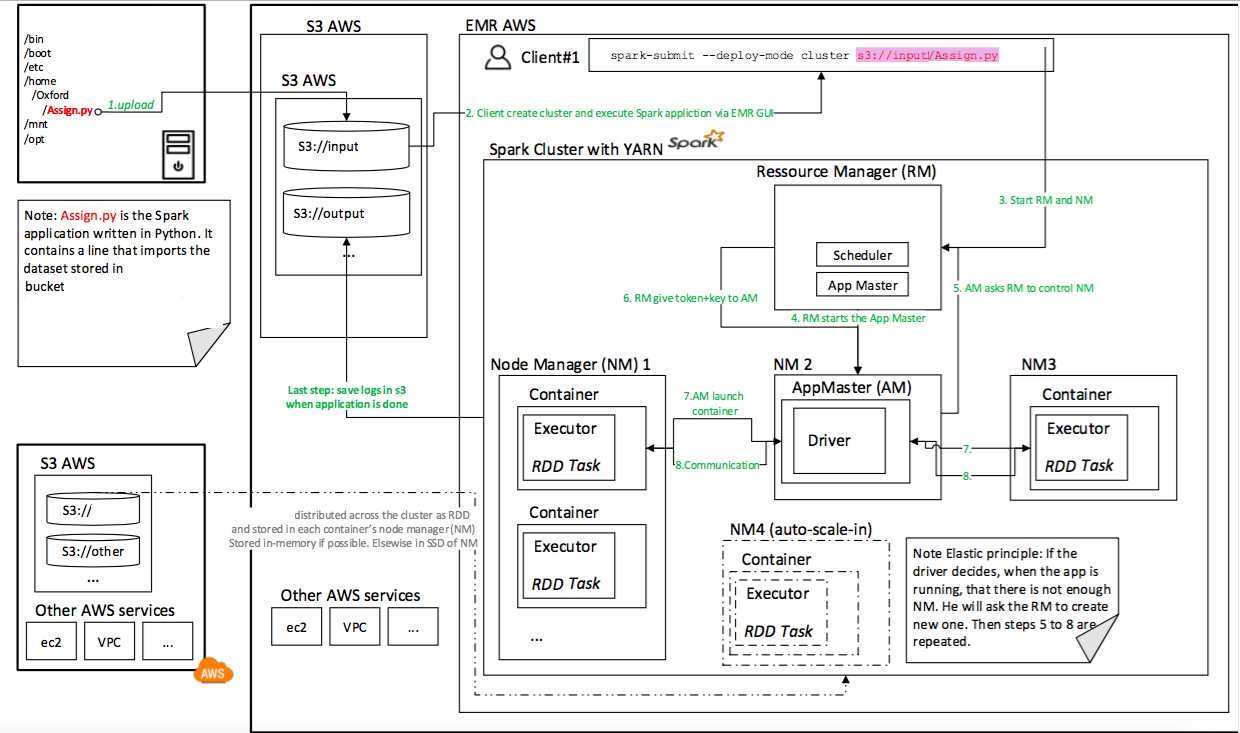

In [9]:
from IPython.display import Image
Image("architecture.jpg")

<p><b>Description:</b></p>
<p  style="text-align:justify"> All the code related to analytics is assumed to be in Assign.py file. That file should be loaded to a S3 bucket under developer's AWS login. Dataset is stored in a S3 bucket belonging to an external organisation. A minimum of 8 nodes and a maximum of 20 nodes is suitable to be chosen when setting up the Spark cluster. Yarn Scale-in and out rules need to be specified based on YARNMemoryAvailablePercentage parameter.</p>

<p style="text-align:justify">spark-submit client launches the Spark application. It is important to note that the client is not running any user code. Client contacts the resource manager and asks it to run application master process.</p>

<p style="text-align:justify">Then the resource manager assigns a node manager to launch the application master in a container. Application master starts and runs the driver programme.</p>

<p style="text-align:justify">Driver programme requests resources from the resource manager, and starts executors in Yarn containers. Then the communication is established between containers and Application Master.</p>

<p style="text-align:justify">Spark programme consists of multiple spark jobs. Directed acyclic graph(DAG) scheduler in Spark creates a DAG of stages for each job. Further task scheduler in Spark will generate tasks for each stage. These RDD tasks are run concurrently within the executors. Each task is associated with a chunk of RDD by the Driver running within the Application Master. This data is coming from external public S3 bucket.</p>
    
<p style="text-align:justify">Data transmission between the external S3 bucket and executors can be minimised via persisting data as required. Yarn also works on maintaining data locality by trying to start executor processes in the same rack or network where data resides.</p>

<p style="text-align:justify">The results of each task is passed back to application master, and results were aggregated as needed to calculate final answers. Final answers as well as log files for each container are then dropped back on S3.</p>

<p style="text-align:justify">
Application master can ask the resource manager to launch new containers if a stage requires more resources during a job execution. Application master can also request to restart a node manager if it crashes. Resource manager can replace application manager in the event of an accident. So that this architecture is fault tolerant and highly available. Further Zookeeper can be used to manage failures of the resource manager.</p>

<p><b>Analytics are presented below using a Jupyter Notebook for demonstration purposes.</b></p>

<h2>Analysis</h2>

In [223]:
from pyspark.sql import SparkSession
from pyspark.sql.types import (StringType,IntegerType, DateType, FloatType, TimestampType)
from pyspark.sql.functions import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [104]:
session= SparkSession.builder.appName('DeutscheBorse').getOrCreate()
# Creates a pyspark.sql.session.SparkSession object.

In [105]:
df= session.read.csv('s3a:/oxclo-dbs/',inferSchema= True, header=True)
# Creates a pyspark.sql.Dataframe object.
df.columns

['ISIN',
 'Mnemonic',
 'SecurityDesc',
 'SecurityType',
 'Currency',
 'SecurityID',
 'Date',
 'Time',
 'StartPrice',
 'MaxPrice',
 'MinPrice',
 'EndPrice',
 'TradedVolume',
 'NumberOfTrades']

In [106]:
# Casts the columns of previous pyspark.sql.Dataframe object.
df = df.withColumn('SecurityID', df['SecurityID'].cast(IntegerType())).\
withColumn('Date',df['Date'].cast(DateType())).\
withColumn('StartPrice', df['StartPrice'].cast(FloatType())).\
withColumn('MaxPrice', df['MaxPrice'].cast(FloatType())).\
withColumn('MinPrice', df['MinPrice'].cast(FloatType())).\
withColumn('EndPrice', df['EndPrice'].cast(FloatType())).\
withColumn('TradedVolume', df['TradedVolume'].cast(FloatType())).\
withColumn('NumberOfTrades', df['NumberOfTrades'].cast(IntegerType()))

In [107]:
df.printSchema()

root
 |-- ISIN: string (nullable = true)
 |-- Mnemonic: string (nullable = true)
 |-- SecurityDesc: string (nullable = true)
 |-- SecurityType: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- SecurityID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- StartPrice: float (nullable = true)
 |-- MaxPrice: float (nullable = true)
 |-- MinPrice: float (nullable = true)
 |-- EndPrice: float (nullable = true)
 |-- TradedVolume: float (nullable = true)
 |-- NumberOfTrades: integer (nullable = true)



According to above Schema, following fields were found for each row.<br/>
<table align="left">
    <tr><th>Column name</th><th>Data description</th></tr>
    <tr><td>ISIN</td><td>ISIN of the security</td></tr>
    <tr><td>Mnemonic</td><td>Stock exchange ticker symbol</td></tr>
    <tr><td>SecurityDesc</td><td>Description of the security</td></tr>
    <tr><td>SecurityType</td><td>Type of security</td></tr>
    <tr><td>Currency</td><td>Currency in which the product is traded</td></tr>
    <tr><td>SecurityID</td><td>Unique identifier for each contract</td></tr>
    <tr><td>Date</td><td>Date of trading period</td></tr>
    <tr><td>Time</td><td>Minute of trading to which this entry relates (hh:mm)</td></tr>
    <tr><td>StartPrice</td><td>Trading price at the start of period</td></tr>
    <tr><td>MaxPrice</td><td>Maximum price over the period</td></tr>
    <tr><td>MinPrice</td><td>Minimum price over the period</td></tr>
    <tr><td>EndPrice</td><td>Trading price at the end of the period</td></tr>
    <tr><td>TradedVolume</td><td>Total value traded</td></tr>
    <tr><td>NumberOfTrades</td><td>Number of distinct trades during the period</td></tr>
</table>


<p><b>Identifying security types:</b></p>

In [108]:
df.select('SecurityType').distinct().show() 

+------------+
|SecurityType|
+------------+
|         ETF|
|Common stock|
|         ETC|
|       Other|
|SecurityType|
|         ETN|
+------------+



<p>It was decided to restrict further analysis to securities belonging to Common stock. The core trading hours of Xetra are Monday to Friday from 07:00	- 17:00	GMT. Then the analysis was further restricted to records between 07:00- 17:00 GMT.</p>

In [109]:
#  filtering records for Common stock
df = df.filter("SecurityType == 'Common stock'") 

In [110]:
# extracting the records between 07:00-17:00 GMT. Two extra columns Hour and Minute were addeed during this step.
df = df.withColumn('Hour',hour('Time')).withColumn('Minute',minute('Time')).\
filter('(Hour >= 7 and Hour <= 16) or (Hour == 17 and Minute ==0)')

<p><b>Summaries for filtered dataset:</b></p>

In [111]:
summaries = df.describe()

In [113]:
summaries.select(['summary','ISIN','Mnemonic','SecurityDesc','SecurityType','Currency','SecurityID']).show()
summaries.select(['summary','Time','StartPrice','MaxPrice','MinPrice','EndPrice']).show()
summaries.select(['summary','TradedVolume','NumberOfTrades']).show()

+-------+------------+------------------+--------------------+------------+--------+------------------+
|summary|        ISIN|          Mnemonic|        SecurityDesc|SecurityType|Currency|        SecurityID|
+-------+------------+------------------+--------------------+------------+--------+------------------+
|  count|    14157388|          14157194|            14157388|    14157388|14157388|          14157388|
|   mean|        null|471.86374804556624|                null|        null|    null|2510452.3088512514|
| stddev|        null|156.29596509702174|                null|        null|    null| 42560.80455021135|
|    min|AT00000AMAG3|               0ME|1+1 DRILLISCH AG ...|Common stock|     EUR|           2504156|
|    max|USN070592100|               ZSB|ZURICH INSUR.GR.N...|Common stock|     EUR|           3299907|
+-------+------------+------------------+--------------------+------------+--------+------------------+

+-------+--------+------------------+------------------+-------

<p> Then Time was matched into 15 minutes of trading periods (e.g 08:00-08:14,08:15-08:29,08:30-08:44,08:45-08:59) for the ease of analysis. After that two previously added extra columns: Hour, Minute were dropped.</p>

In [114]:
# a function to return the time period when hour and minute is given
def getPeriod(hour,minute):
    if(minute>=0 and minute <=14):
        return str(hour)+":"+"00"+"-"+str(hour)+":"+"14"
    elif (minute>=15 and minute <=29):
        return str(hour)+":"+"15"+"-"+str(hour)+":"+"29"
    elif (minute>=30 and minute <=44):
        return str(hour)+":"+"30"+"-"+str(hour)+":"+"44"
    elif (minute>=45 and minute <=59):
        return str(hour)+":"+"45"+"-"+str(hour)+":"+"59"
    else:
        return "Incorrect hour or minute value"
    

# registering function with udf  
getPeriodUdf = udf(getPeriod,StringType())

# Adding Period column and dropping Hour, Minute
df = df.withColumn("Period",getPeriodUdf("Hour","Minute"))
df = df.drop('Hour').drop('Minute')

<p>Volatility for each row is equal to the absolute value of ((EndPrice - StartPrice)/ StartPrice). So for each row volatility was calculated and stored in a new column called 'Volatility'</p>

In [115]:
# At first we calculate volatility for each row and store in a new column. 
df = df.withColumn('Volatility', round(abs((col('EndPrice')-col('StartPrice'))/col('StartPrice')),2))

<p>After that DataFrame was persisted, and analysis was continued.</p>

In [116]:
# persisting the dataframe 
df.persist()

DataFrame[ISIN: string, Mnemonic: string, SecurityDesc: string, SecurityType: string, Currency: string, SecurityID: int, Date: date, Time: string, StartPrice: float, MaxPrice: float, MinPrice: float, EndPrice: float, TradedVolume: float, NumberOfTrades: int, Period: string, Volatility: double]

<p><b>Finding top ten number of trades of all securities along with dates:</b></p>

In [117]:
# Group by Date and find the addition of NumberOfTrades per each day 
# ordering TotalNumberOfTrades in descending order
df_trades = df.groupBy('Date').agg({'NumberOfTrades':'sum'}).orderBy(col('sum(NumberOfTrades)').desc())
df_trades.show(10)

+----------+-------------------+
|      Date|sum(NumberOfTrades)|
+----------+-------------------+
|2018-02-06|             826192|
|2018-04-10|             659437|
|2018-04-13|             649049|
|2018-04-11|             645804|
|2018-02-09|             628675|
|2018-04-18|             562204|
|2018-04-20|             553522|
|2018-04-17|             533241|
|2017-11-09|             530204|
|2018-04-09|             529586|
+----------+-------------------+
only showing top 10 rows



<p><b>Plotting a line graph of sum(NumberOfTrades) vs Date:</b></p>

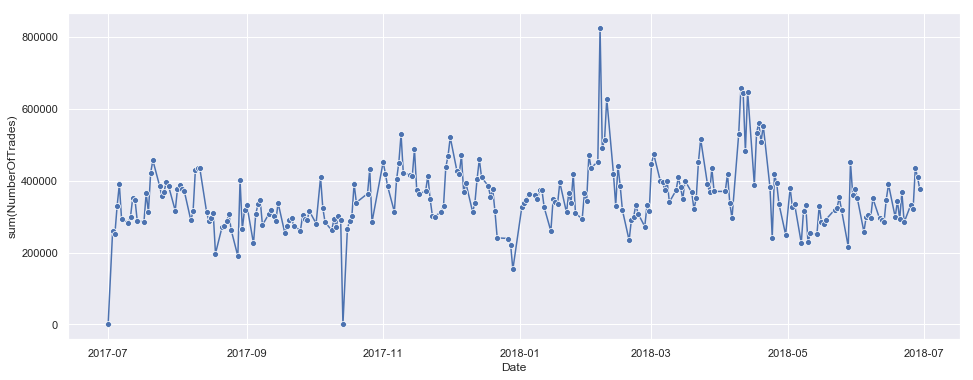

In [118]:
plt.figure(figsize=(16, 6))
sns.set()
lineGraph = sns.lineplot(x="Date", y="sum(NumberOfTrades)",data=df_trades.toPandas(),marker="o",lw=1.5)

<p><b>Identifying dates with very few number of trades:</b></p>
<p>Above Dataframe df_trades was described. After that Quartile 1 (Q1), Quartile 2 (Q2) which is also the Median,  
Quartile 3 (Q3) were calculated for sum(NumberOfTrades) column. Then the distribution of sum(NumberOfTrades) was plotted on a graph.</p>

<p>After that Inter Quartile range (IQR) for sum(NumberOfTrades) column was calculated. Based on the IQR and Q1, Q1-1.5*IQR was calculated.</p>

+-------+-------------------+
|summary|sum(NumberOfTrades)|
+-------+-------------------+
|  count|                250|
|   mean|         353002.624|
| stddev|  90798.82456156395|
|    min|                  2|
|    max|             826192|
+-------+-------------------+

Quartile 1 (Q1) =295546.0
Quartile 2 (Q2) =339852.0
Quartile 3 (Q3) =395873.0
Inter Quartile range (IQR) =100327.0
Q1-1.5*IQR =145055.5


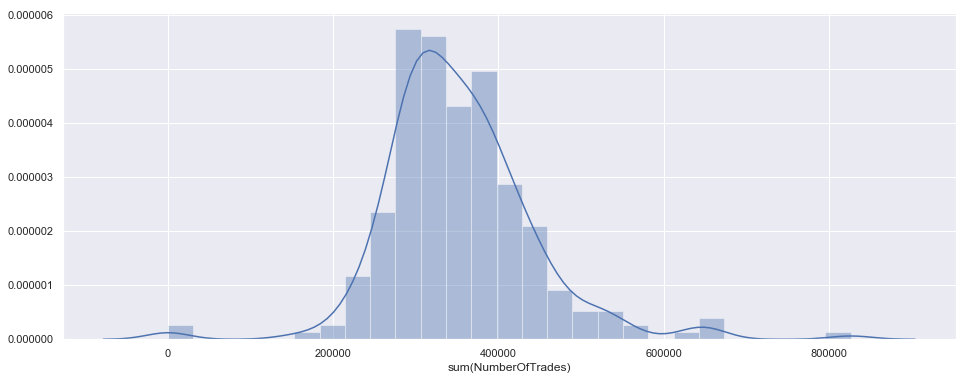

In [119]:
df_trades.describe().show()
quantiles = df_trades.approxQuantile("sum(NumberOfTrades)", [0.25, 0.5,0.75], 0)
print('Quartile 1 (Q1) ='+ str(quantiles[0]))
print('Quartile 2 (Q2) ='+ str(quantiles[1]))
print('Quartile 3 (Q3) ='+ str(quantiles[2]))

plt.figure(figsize=(16, 6))
sns.distplot(df_trades.toPandas()['sum(NumberOfTrades)'])

IQR = quantiles[2]-quantiles[0]
print('Inter Quartile range (IQR) ='+ str(IQR))
low_outliers = quantiles[0]-1.5*IQR
print('Q1-1.5*IQR ='+ str(low_outliers))

<p>Then sum(NumberOfTrades) values lower than Q1-1.5*IQR were identified as few, and such sum(NumberOfTrades) values were displayed alongside corresponding dates.</p>

In [120]:
df_trades.withColumnRenamed('sum(NumberOfTrades)','sumOfTrades').filter('sumOfTrades < 145055').show()

+----------+-----------+
|      Date|sumOfTrades|
+----------+-----------+
|2017-07-01|        910|
|2017-10-14|          2|
+----------+-----------+



<p><b>Finding securities that had top ten volatility in price during one day of trading, along with date: </b></p>

In [121]:
# We group trading based on the ISIN, Mnemonic, SecurityDesc, Date and find the sum of volatilities per each distinct 
# combination.Then we order the sum of volatilities in the descending order.
df_volatility = df.groupBy(['ISIN','Mnemonic','SecurityDesc','Date']).sum('Volatility').orderBy(col('sum(Volatility)').desc()).\
withColumn('sum(Volatility)', round(col('sum(Volatility)'),2))
df_volatility.show(10)

+------------+--------+--------------------+----------+---------------+
|        ISIN|Mnemonic|        SecurityDesc|      Date|sum(Volatility)|
+------------+--------+--------------------+----------+---------------+
|SE0006027546|    SVAB|STOCKHOLM IT VENT...|2017-12-07|           4.76|
|DE000A1TNV91|     ADE|BITCOIN GROUP SE ...|2017-09-05|           4.74|
|SE0006027546|    SVAB|STOCKHOLM IT VENT...|2018-02-07|           4.72|
|NL0011375019|     SNH|STEINHOFF INT.HLD...|2017-12-08|           4.03|
|SE0006027546|    SVAB|STOCKHOLM IT VENT...|2017-12-08|           3.93|
|SE0006027546|    SVAB|STOCKHOLM IT VENT...|2017-11-29|           3.75|
|GB00B128C026|     AB1|AIR BERLIN PLC   ...|2017-10-12|           3.72|
|DE000A1TNV91|     ADE|BITCOIN GROUP SE ...|2017-08-11|            3.3|
|NL0011375019|     SNH|STEINHOFF INT.HLD...|2017-12-06|           3.13|
|DE000A1TNV91|     ADE|BITCOIN GROUP SE ...|2017-09-04|           3.07|
+------------+--------+--------------------+----------+---------

<p><b>Plotting above result in a strip plot, without altering the descending order of rows:</b></p>

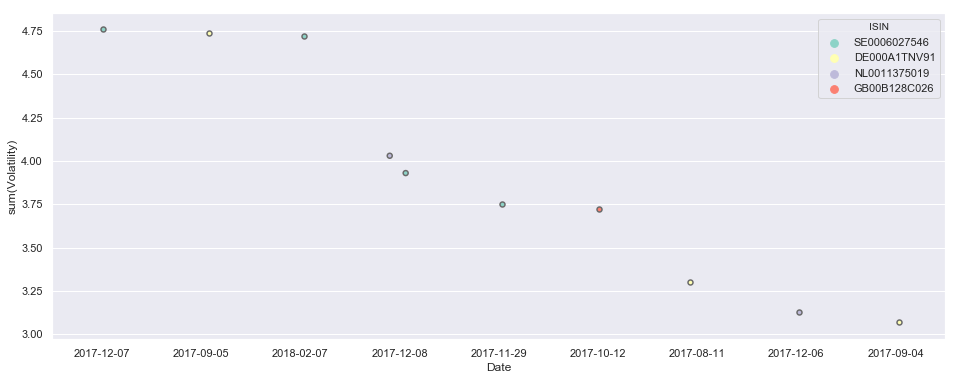

In [122]:
pd_volatility = df_volatility.limit(10).select(['ISIN','Date','sum(Volatility)']).toPandas()
plt.figure(figsize=(16, 6))
sns.set()
sns.stripplot(x="Date", y="sum(Volatility)", data=pd_volatility,hue='ISIN',marker="o",lw=1.5,palette='Set3')

<p><b>Calculating the total volume of trades and total gain on each day by security: </b></p>
<p>Gain for each row was calculated using formula (EndPrice-StartPrice) * TradedVolume.</p>

In [125]:
# Following procedure was followed to find the results.
# 1. Calculating the Gain for each row using formula (EndPrice-StartPrice) * TradedVolume 
# 2. Adding Gain as a column. If gain is a minus value it is a loss. 
# 3. Grouping tradings based on ISIN,Mnemonic,SecurityDesc,Date and calculating sum of TradedVolume and sum of Gain 
#    for each unique ISIN,Mnemonic,SecurityDesc,Date combination
# 4. Rounding TotalGain to two decimal places 

df_volume_gain = df.withColumn('Gain', (col('EndPrice')-col('StartPrice'))*col('TradedVolume')).\
groupBy(['ISIN','Mnemonic','SecurityDesc','Date']).sum('TradedVolume','Gain').\
withColumnRenamed('sum(TradedVolume)','TotalVolume').\
withColumnRenamed('sum(Gain)','TotalGain')

df_volume_gain = df_volume_gain.withColumn("TotalGain", round(df_volume_gain["TotalGain"], 2))
df_volume_gain.orderBy(col('Date').desc(),col('TotalGain').desc()).show()

+------------+--------+--------------------+----------+-----------+---------+
|        ISIN|Mnemonic|        SecurityDesc|      Date|TotalVolume|TotalGain|
+------------+--------+--------------------+----------+-----------+---------+
|DE000LED4000|     OSR|OSRAM LICHT AG NA...|2018-06-29|  2768385.0|  71522.8|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-29|2.0414813E7| 35581.98|
|DE0005937007|     MAN|      MAN SE ST O.N.|2018-06-29|   293386.0| 32817.13|
|DE0008430026|    MUV2|MUENCH.RUECKVERS....|2018-06-29|   624389.0| 20076.59|
|DE000CBK1001|     CBK|      COMMERZBANK AG|2018-06-29|1.0808114E7| 19719.28|
|DE0006062144|    1COV|   COVESTRO AG  O.N.|2018-06-29|  1056130.0|  16918.4|
|DE000A12UKK6|    RKET|  ROCKET INTERNET SE|2018-06-29|   819133.0|  16519.0|
|DE0005773303|     FRA|FRAPORT AG FFM.AI...|2018-06-29|   153038.0| 15346.69|
|DE000ZAL1111|     ZAL|          ZALANDO SE|2018-06-29|   551708.0|  11222.7|
|DE000WCH8881|     WCH|WACKER CHEMIE    ...|2018-06-29|   157091

<p><b>Using previous result and identifying the security with the greatest volume of trades for each day, together with the total gain or loss in price from the start of the day to the end of trading: </b></p>

In [126]:
# Procedure
# 1. Mapping the current dataframe to a table
# 2. Self left joining of the table and selecting the rows where there is highest volume for each Date.

df_volume_gain.createOrReplaceTempView('tmp')
df_volume_gain = session.sql("select t1.* from tmp t1 left join tmp t2 on t1.Date = t2.Date and t1.TotalVolume < t2.TotalVolume where t2.TotalVolume is null")     

# 3. Order by Date in descending order 
df_volume_gain= df_volume_gain.orderBy(col('Date').desc())
df_volume_gain.show()

+------------+--------+--------------------+----------+------------+---------+
|        ISIN|Mnemonic|        SecurityDesc|      Date| TotalVolume|TotalGain|
+------------+--------+--------------------+----------+------------+---------+
|NL0011375019|     SNH|STEINHOFF INT.HLD...|2018-06-29| 4.9666772E7|-13238.85|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-28| 1.3834404E7|-13313.08|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-27| 2.8470965E7| 10938.86|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-26| 1.0537911E7| -7495.27|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-25| 1.0372367E7| -4801.32|
|NL0011375019|     SNH|STEINHOFF INT.HLD...|2018-06-22| 1.2476609E7|  -200.29|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-21| 1.5513053E7|-11573.01|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-20| 1.3305375E7|-13820.65|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-19| 1.4126286E7| 26020.92|
|NL0011375019|     SNH|STEINHOFF INT.HLD...|2018-06-

<p><b>Plotting top twenty rows of previous result:</b> </p>
<p>According to plot, for last twenty days highest total volume was among two securities: NL0011375019 and DE0005140008.</p>

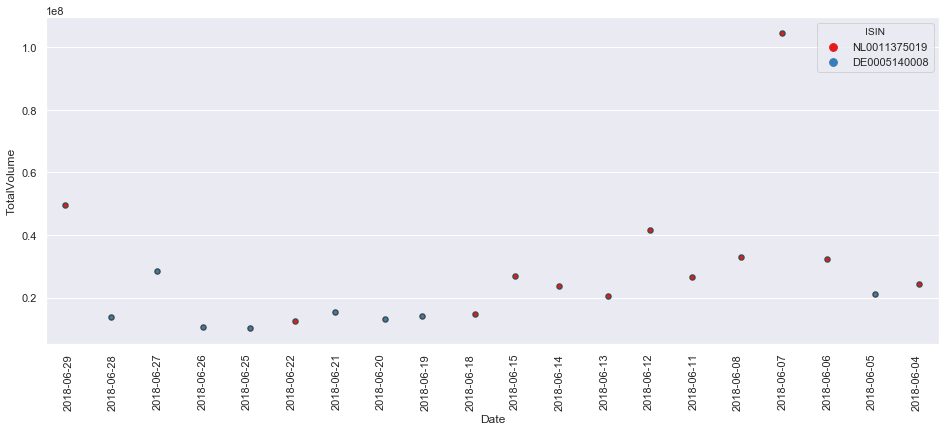

In [127]:
pd_volume_gain = df_volume_gain.limit(20).select(['ISIN','Date','TotalVolume']).toPandas()
plt.figure(figsize=(16, 6))
sns.set()
g = sns.stripplot(x="Date", y="TotalVolume", data=pd_volume_gain,hue='ISIN',marker="o",lw=1.5,palette='Set1')
set_x_ticks = g.set_xticklabels(g.get_xticklabels(),rotation=90)

<p><b>Identifying any new securities that were launched during this data period:</b></p>
<p>For each such security the day of launch, the total trade volume on the first day, mnemonic and the description of the security are extracted.</p>
<p>Assumption: Every security gets traded at least once in a day.</p>

In [128]:
# filtering the rows where TradedVolume == 0. A row with tradedVolume 0 corresponds to introduction of a security.   
df_zero_volume = df.filter('TradedVolume == 0').drop('TradedVolume')
# Date coloumn in df_zero_volume contains the introducedDate.

df_newSec= df.join(df_zero_volume,['ISIN','Mnemonic','SecurityDesc','Date']).filter('TradedVolume>0').\
groupBy(['ISIN','Mnemonic','SecurityDesc','Date']).sum('TradedVolume')

# After joining , result contained all the rows corresponding to introductory date of each security. 
# It was again filtered based on the condition : TradedVolume>0
# Then it contained records regarding first day trades for all new securities.
# Then the result was grouped by 'ISIN','Mnemonic','SecurityDesc','Date' and sum of TradedVolume for each combination
#was calculated.

print(str(df_newSec.count())+" new securities were added during the period.")


# Finding the new securities with highest sum of TradedVolume on the very first day. 
df_newSec.orderBy(col('sum(TradedVolume)').desc()).show()

3365 new securities were added during the period.
+------------+--------+--------------------+----------+-----------------+
|        ISIN|Mnemonic|        SecurityDesc|      Date|sum(TradedVolume)|
+------------+--------+--------------------+----------+-----------------+
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2017-11-13|      1.6140017E7|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-06-14|      1.5403221E7|
|DE0005557508|     DTE|    DT.TELEKOM AG NA|2018-04-10|      1.3191303E7|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2018-04-19|       1.290585E7|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2017-08-17|      1.2875184E7|
|DE000CBK1001|     CBK|      COMMERZBANK AG|2018-03-23|      1.1498446E7|
|DE0005140008|     DBK|DEUTSCHE BANK AG ...|2017-07-21|      1.1226505E7|
|DE000ENAG999|    EOAN|     E.ON SE NA O.N.|2018-04-23|      1.0678847E7|
|DE000ENAG999|    EOAN|     E.ON SE NA O.N.|2018-05-02|      1.0253167E7|
|DE000CBK1001|     CBK|      COMMERZBANK AG|2018-06-05|      1

<p><b>Calculating the open, close, high, low prices for each security together with the total volume and number of trades over each 15 minutes of trading period (e.g. 08:00-08:14, 08:15-08:29, etc.) </b></p>

In [134]:
# grouping based on ISIN,Mnemonic,Date,Period and calculating max(MaxPrice), min(MinPrice)
# sum(TradedVolume), sum(NumberOfTrades),min(Time), max(Time) 
df.createOrReplaceTempView('df')
df_stg1 = session.sql("select ISIN,Mnemonic,Date,Period,max(MaxPrice) as c_MaxPrice, min(MinPrice) as c_MinPrice,"+ 
                "sum(TradedVolume) as c_TradedVolume ,sum(NumberOfTrades) as c_NumberOfTrades,"+
                "min(Time) as minTime,max(Time) as maxTime from df group by ISIN,Mnemonic,Date,Period")

df_stg1.createOrReplaceTempView('df_stg1')
print(df_stg1.columns)

['ISIN', 'Mnemonic', 'Date', 'Period', 'c_MaxPrice', 'c_MinPrice', 'c_TradedVolume', 'c_NumberOfTrades', 'minTime', 'maxTime']


In [135]:
# joining df with df_stg1 to find startPrice for the durations 
df_stg2 = session.sql("select df_stg1.*,df.StartPrice from df join df_stg1 on df.ISIN = df_stg1.ISIN and "+
                      "df.Date = df_stg1.Date and df.Period = df_stg1.Period and df.Time = df_stg1.minTime").\
drop('minTime')
print(df_stg2.columns)

['ISIN', 'Mnemonic', 'Date', 'Period', 'c_MaxPrice', 'c_MinPrice', 'c_TradedVolume', 'c_NumberOfTrades', 'maxTime', 'StartPrice']


In [136]:
# joining df_stg2 with df_helper to find endPrice for the durations 
df_helper = df.select(['ISIN','Date','Period','Time','EndPrice']).withColumnRenamed('Time','maxTime')
df_stg3 = df_stg2.join(df_helper,['ISIN','Date','Period','maxTime']).drop('maxTime')

df_stg3= df_stg3.withColumnRenamed('c_StartPrice','StartPrice').\
withColumnRenamed('c_MaxPrice','MaxPrice').\
withColumnRenamed('c_MinPrice','MinPrice').\
withColumnRenamed('c_TradedVolume','TradedVolume').\
withColumnRenamed('c_NumberOfTrades','NumberOfTrades').\
select(['ISIN','Mnemonic','Date','Period','StartPrice','EndPrice','MaxPrice','MinPrice','TradedVolume','NumberOfTrades']).\
orderBy(col('Date').desc())

df_stg3.show(10)
df_stg3.persist()

+------------+--------+----------+-----------+----------+--------+--------+--------+------------+--------------+
|        ISIN|Mnemonic|      Date|     Period|StartPrice|EndPrice|MaxPrice|MinPrice|TradedVolume|NumberOfTrades|
+------------+--------+----------+-----------+----------+--------+--------+--------+------------+--------------+
|DE0005408884|     LEO|2018-06-29|  7:45-7:59|     43.65|   43.78|    43.8|   43.58|      7178.0|            59|
|DE0006450000|     LPK|2018-06-29|  9:15-9:29|      7.18|    6.99|    7.19|    6.99|       739.0|             4|
|DE0005439004|     CON|2018-06-29|  8:45-8:59|    198.25|  197.95|  198.35|   197.9|     12041.0|           143|
|DE0005168108|     B5A|2018-06-29|15:00-15:14|     18.94|   18.96|   18.96|   18.94|       621.0|             5|
|DE0005495329|     HOC|2018-06-29|  7:45-7:59|      3.13|    3.13|    3.13|    3.13|      2000.0|             1|
|DE0005140008|     DBK|2018-06-29|11:30-11:44|     9.146|   9.175|   9.175|   9.125|    394935.0

DataFrame[ISIN: string, Mnemonic: string, Date: date, Period: string, StartPrice: float, EndPrice: float, MaxPrice: float, MinPrice: float, TradedVolume: double, NumberOfTrades: bigint]

In [137]:
# a function to return next time period, when a time period is given.
# This function internally calls getPeriod function

def getNextPeriod(period):
    endTime = period.split("-")[1]
    hour = int(endTime.split(":")[0])
    minute = int(endTime.split(":")[1])
    if(minute == 14 or minute ==29 or minute == 44):
        return getPeriod(hour,minute+1) 
    elif(minute==59 and hour==23):
        return getPeriod(0,0)
    elif(minute == 59):
        return getPeriod(hour+1,0)
    else: 
        return "Invalid period endTime"

getNextPeriodUdf = udf(getNextPeriod,StringType())

<p><b>Calculating the ratio of change in price to the start price for each 15 minute period for each stock:</b></p>

In [141]:
# adding nextTimePeriod as a column to DataFrame 
df_stg4 = df_stg3.withColumn("nextTimePeriod",getNextPeriodUdf('Period')).\
select(['ISIN','Mnemonic','Date','Period','nextTimePeriod','StartPrice'])

df_stg4.createOrReplaceTempView('df_stg4')
df_stg4.columns

['ISIN', 'Mnemonic', 'Date', 'Period', 'nextTimePeriod', 'StartPrice']

In [117]:
# self joining
df_stg5 = session.sql("select t1.*, t2.StartPrice as nextStartPrice from df_stg4 t1 join df_stg4 t2 "+ 
                      "on t1.ISIN = t2.ISIN and t1.Date = t2.Date and t1.nextTimePeriod = t2.Period").\
withColumn('RatioOfStartPriceChange',format_number((col('nextStartPrice')-col('StartPrice'))/col('StartPrice'),3)).\
drop('StartPrice').drop('nextStartPrice')

df_stg5.show()

+------------+--------+----------+-----------+--------------+-----------------------+
|        ISIN|Mnemonic|      Date|     Period|nextTimePeriod|RatioOfStartPriceChange|
+------------+--------+----------+-----------+--------------+-----------------------+
|AT00000FACC2|     1FC|2017-12-08|14:15-14:29|   14:30-14:44|                  0.003|
|AT00000FACC2|     1FC|2018-01-03|  8:45-8:59|     9:00-9:14|                 -0.002|
|AT00000FACC2|     1FC|2018-01-16|10:30-10:44|   10:45-10:59|                  0.001|
|AT00000FACC2|     1FC|2018-05-25|15:00-15:14|   15:15-15:29|                 -0.023|
|AT00000FACC2|     1FC|2018-06-15|  8:45-8:59|     9:00-9:14|                 -0.003|
|AT0000603709|    AGB1|2018-01-18|10:30-10:44|   10:45-10:59|                 -0.008|
|AT0000606306|     RAW|2017-07-19|13:15-13:29|   13:30-13:44|                  0.002|
|AT0000606306|     RAW|2017-07-25|10:15-10:29|   10:30-10:44|                  0.022|
|AT0000606306|     RAW|2017-07-28|  8:45-8:59|     9:0

<p><b>Comparing Daimler and BMW, and checking whether there is a correlation between the two securities when considering this ratio: <b></p>

In [166]:
df_stg6 = df_stg5.drop('ISIN')
df_BMW = df_stg6.where("Mnemonic == 'BMW'").withColumnRenamed('RatioOfStartPriceChange','BMWRatio').drop('Mnemonic')
df_DAI = df_stg6.where("Mnemonic == 'DAI'").withColumnRenamed('RatioOfStartPriceChange','DAIRatio').drop('Mnemonic')

df_joined = df_BMW.join(df_DAI,['Date','Period','nextTimePeriod'])
df_joined.show(5)

rddForAnalysis = df_joined.rdd.map(lambda (D,P1,P2,BMW,DAI):Vectors.dense([BMW,DAI]))
corr_matrix = Statistics.corr(rddForAnalysis)
corr_matrix

+----------+-----------+--------------+--------+--------+
|      Date|     Period|nextTimePeriod|BMWRatio|DAIRatio|
+----------+-----------+--------------+--------+--------+
|2017-07-03|15:00-15:14|   15:15-15:29|  -0.001|  -0.001|
|2017-07-11|13:45-13:59|   14:00-14:14|   0.001|   0.002|
|2017-07-20|  7:15-7:29|     7:30-7:44|   0.000|  -0.001|
|2017-07-27|  7:15-7:29|     7:30-7:44|  -0.001|   0.001|
|2017-08-09|  9:45-9:59|   10:00-10:14|  -0.001|  -0.002|
+----------+-----------+--------------+--------+--------+
only showing top 5 rows



array([[1.        , 0.70800616],
       [0.70800616, 1.        ]])

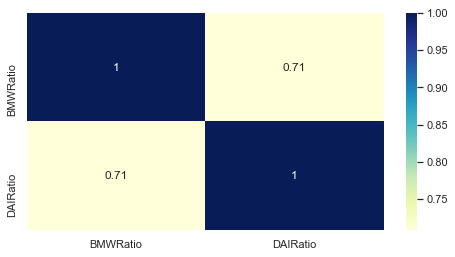

In [185]:
pd_BMWRatio_DAIRatio= pd.DataFrame.from_records(corr_matrix)
pd_BMWRatio_DAIRatio.columns = ['BMWRatio', 'DAIRatio']
pd_BMWRatio_DAIRatio.index = ['BMWRatio', 'DAIRatio']

plt.figure(figsize=(8, 4))
sns.set()
sns.heatmap(pd_BMWRatio_DAIRatio,cmap='YlGnBu',annot=True)

<p>So that there is a correlation between ratio for BMW and Daimler. </p>
<p><b>sum(TradedVolume), MaxPrice and MinPrice per hour for BMW on 1st November 2017:</b></p>

In [187]:
graphDf = df.withColumn('Hour',hour('Time'))
df_2017_11_01 = graphDf.filter("Date='2017-11-01'")
df_2017_11_01_BMW = df_2017_11_01.where("Mnemonic =='BMW'").groupBy('Hour').\
agg({'TradedVolume':'sum','MinPrice':'min','MaxPrice':'max'}).orderBy(col('Hour').asc())

df_2017_11_01_BMW.show()

+----+-----------------+-------------+-------------+
|Hour|sum(TradedVolume)|max(MaxPrice)|min(MinPrice)|
+----+-----------------+-------------+-------------+
|   8|         240517.0|        88.99|        88.02|
|   9|         160241.0|        89.13|        88.73|
|  10|         153253.0|        89.38|        89.04|
|  11|         110418.0|         89.5|        89.28|
|  12|          83011.0|        89.63|        89.37|
|  13|         149399.0|        89.71|        89.39|
|  14|         279152.0|        89.97|        89.64|
|  15|         178395.0|        89.94|        89.65|
|  16|         139425.0|         89.9|        89.58|
+----+-----------------+-------------+-------------+



<p><b>sum(TradedVolume), MaxPrice and MinPrice per hour for Daimler on 1st November 2017:</b></p>

In [188]:
df_2017_11_01_DAI = df_2017_11_01.where("Mnemonic =='DAI'").groupBy('Hour').\
agg({'TradedVolume':'sum','MinPrice':'min','MaxPrice':'max'}).orderBy(col('Hour').asc())

df_2017_11_01_DAI.show()

+----+-----------------+-------------+-------------+
|Hour|sum(TradedVolume)|max(MaxPrice)|min(MinPrice)|
+----+-----------------+-------------+-------------+
|   8|         943737.0|        72.74|         71.8|
|   9|         367368.0|        72.73|        72.38|
|  10|         365582.0|        72.84|        72.59|
|  11|         184788.0|         72.8|        72.59|
|  12|         214185.0|         72.9|        72.73|
|  13|         297163.0|        72.97|        72.75|
|  14|         318053.0|         73.0|        72.85|
|  15|         369735.0|         73.0|        72.88|
|  16|         436626.0|        73.14|        72.92|
+----+-----------------+-------------+-------------+



<p><b>Plotting statistics for 1st November 2017 showing a comparison of BMW and Daimler: </b></p>

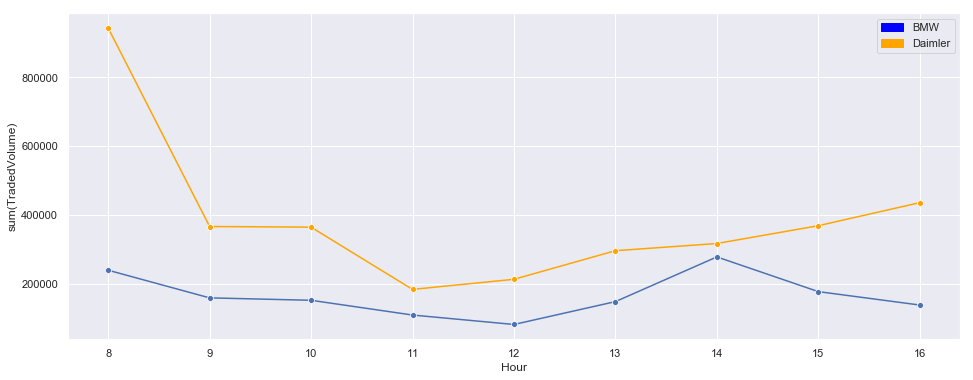

In [227]:
pd_BMW = df_2017_11_01_BMW.toPandas()
pd_DAI = df_2017_11_01_DAI.toPandas()
BMW_handler = mpatches.Patch(color='blue', label='BMW')
DAI_handler = mpatches.Patch(color='orange', label='Daimler')

plt.figure(figsize=(16, 6))
plt.legend(handles=[BMW_handler,DAI_handler])

sns.set()
g = sns.lineplot(x="Hour", y="sum(TradedVolume)",data=pd_BMW,marker="o",lw=1.5)
sns.lineplot(x="Hour", y="sum(TradedVolume)",data=pd_DAI,marker="o",lw=1.5, color='orange')

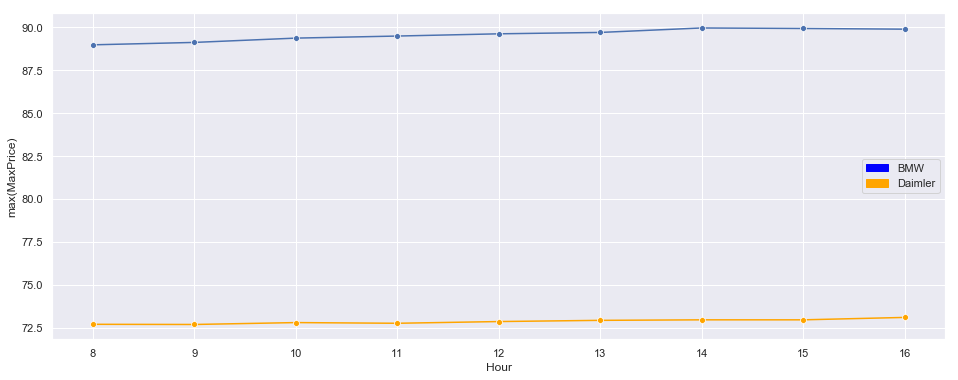

In [229]:
plt.figure(figsize=(16, 6))
plt.legend(handles=[BMW_handler,DAI_handler])

sns.set()
g = sns.lineplot(x="Hour", y="max(MaxPrice)",data=pd_BMW,marker="o",lw=1.5)
sns.lineplot(x="Hour", y="max(MaxPrice)",data=pd_DAI,marker="o",lw=1.5, color='orange')

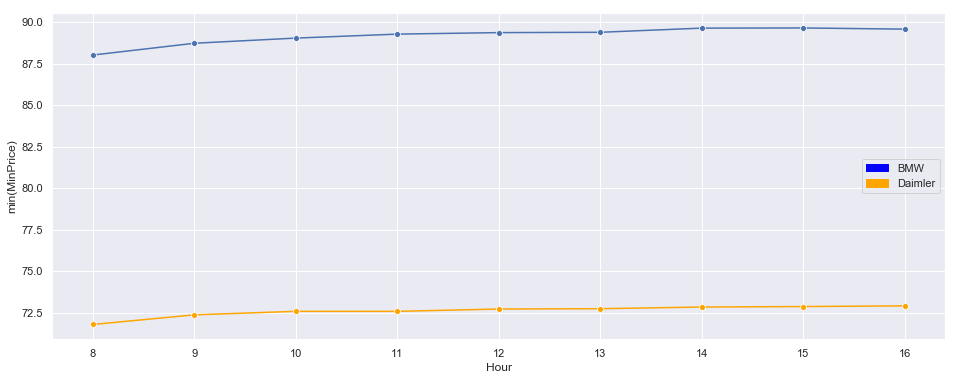

In [230]:
plt.figure(figsize=(16, 6))
plt.legend(handles=[BMW_handler,DAI_handler])

sns.set()
g = sns.lineplot(x="Hour", y="min(MinPrice)",data=pd_BMW,marker="o",lw=1.5)
sns.lineplot(x="Hour", y="min(MinPrice)",data=pd_DAI,marker="o",lw=1.5, color='orange')

<p><b>Checking for a correlation between volatility and trading volume across all common stock:</b></p>

In [232]:
df_joined = df.groupBy(['ISIN','Date']).agg({'Volatility':'sum','TradedVolume':'sum'}).\
orderBy(col('sum(Volatility)').desc())

rddForAnalysis = df_joined.rdd.map(lambda (I,D,sV,sT):Vectors.dense([sV,sT]))
corr_matrix = Statistics.corr(rddForAnalysis)
corr_matrix

array([[1.        , 0.38642136],
       [0.38642136, 1.        ]])

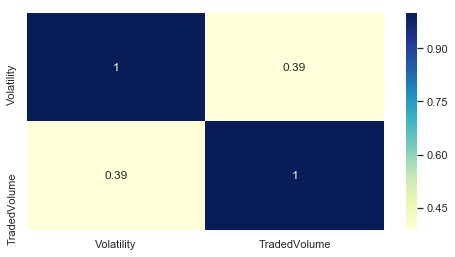

In [233]:
pd_volatility_volume= pd.DataFrame.from_records(corr_matrix)
pd_volatility_volume.columns = ['Volatility', 'TradedVolume']
pd_volatility_volume.index = ['Volatility', 'TradedVolume']

plt.figure(figsize=(8, 4))
sns.set()
sns.heatmap(pd_volatility_volume,cmap='YlGnBu',annot=True)

<p>So that a correlation between volatility and trading volume was not found. </p>

In [2]:
# HTML used for visualization 
from IPython.core.display import HTML
HTML("""
<style> 
h1,h2,p,table,h4{font-family: Helmet, Freesans, Helvetica, Arial, sans-serif;}
h2{padding:0}
p,h4{ font-size: 18px;}
tr{font-size: 16px;}

</style>
""")